In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/Shareddrives/IA - Detección de Plagio - 8vo/reto"
!ls

/content/drive/Shareddrives/IA - Detección de Plagio - 8vo/reto
 000.java	'1 LogisticRegression.ipynb'   limpieza.ipynb
 001.java	'3 CNN.ipynb'		       max_length.joblib
 003.java	 5449d33c.java		       modelo2.ipynb
 004.java	'5 Loaded Model.ipynb'	       procesado.ipynb
 00af3420.java	'6 Identifier.ipynb'	       RandomForestClassifier.ipynb
 017.java	 base.csv		       tokenizer.joblib
 022.java	 classifier.joblib	       versions


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [4]:
def get_code(text):
    # punctuation = ["_", "-", ".", ":", ",", ";", "(", ")", "?", "¿", "¡", "!", '"', "{", "}", "[", "]", "+", "*", "=", "/", "%", "<", ">"]
    # for i in punctuation:
    #     text = text.replace(i, " ")
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    return text

In [5]:
# Paso 1: Preparación de los datos
data = pd.read_csv('base.csv')
data['Code1'] = data['Code1'].apply(get_code)
data['Code2'] = data['Code2'].apply(get_code)

features = data[['Code1', 'Code2']]
labels = data['verdict']

# Paso 2: Convertir los valores de similitud en etiquetas binarias
# binarizer = LabelBinarizer()
# labels = binarizer.fit_transform(labels)

# Paso 3: División de los datos
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [6]:
# Paso 4: Tokenizar los códigos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Code1'] + X_train['Code2'])
train_sequences_code1 = tokenizer.texts_to_sequences(X_train['Code1'])
train_sequences_code2 = tokenizer.texts_to_sequences(X_train['Code2'])
test_sequences_code1 = tokenizer.texts_to_sequences(X_test['Code1'])
test_sequences_code2 = tokenizer.texts_to_sequences(X_test['Code2'])

In [7]:
# Paso 5: Padding de las secuencias para que tengan la misma longitud
max_length = max(max(len(seq) for seq in train_sequences_code1), max(len(seq) for seq in train_sequences_code2),
                 max(len(seq) for seq in test_sequences_code1), max(len(seq) for seq in test_sequences_code2))
train_sequences_code1 = pad_sequences(train_sequences_code1, maxlen=max_length)
train_sequences_code2 = pad_sequences(train_sequences_code2, maxlen=max_length)
test_sequences_code1 = pad_sequences(test_sequences_code1, maxlen=max_length)
test_sequences_code2 = pad_sequences(test_sequences_code2, maxlen=max_length)

In [8]:
train_sequences_code1

array([[   0,    0,    0, ...,    3,   13,    1],
       [   0,    0,    0, ...,  152,  106,   82],
       [   0,    0,    0, ...,  139, 1438,  139],
       ...,
       [   0,    0,    0, ...,   13,    3,   22],
       [   0,    0,    0, ...,   14,   28,   76],
       [   0,    0,    0, ...,   27,   51, 1452]], dtype=int32)

In [9]:
# Paso 6: Entrenamiento del modelo
input_dim = max(tokenizer.word_index.values()) + 1
classifier = RandomForestClassifier()
classifier.fit(train_sequences_code1 + train_sequences_code2, y_train)

RandomForestClassifier()

In [10]:
# Paso 7: Evaluación del modelo
y_pred = classifier.predict(test_sequences_code1 + test_sequences_code2)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Exactitud (Accuracy): {:.2f}%".format(accuracy * 100))
print("Precisión (Precision): {:.2f}%".format(precision * 100))
print("Recuperación (Recall): {:.2f}%".format(recall * 100))
print("Puntuación F1 (F1 Score): {:.2f}%".format(f1 * 100))

Exactitud (Accuracy): 83.06%
Precisión (Precision): 100.00%
Recuperación (Recall): 36.73%
Puntuación F1 (F1 Score): 53.73%


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       134
           1       1.00      0.37      0.54        49

    accuracy                           0.83       183
   macro avg       0.91      0.68      0.72       183
weighted avg       0.86      0.83      0.80       183



In [14]:
import joblib
filename = 'classifier.joblib'
joblib.dump(classifier, filename)

['classifier.joblib']

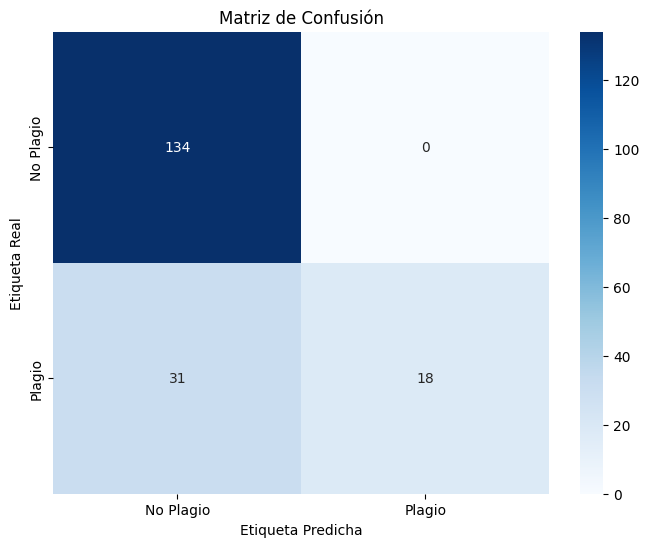

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ['No Plagio', 'Plagio']

# Paso 7: Evaluación del modelo
y_pred = classifier.predict(test_sequences_code1 + test_sequences_code2)

# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión en un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

plt.show()
